# Muckrock Requests Data Analysis #

Included below is the code used to clean and analyze the Muckrock Request data as well as the preview of the analysis results. Full results are exported to .csv files and moved to the "analysis results" folder to prevent the notebook from being clogged.

The .to_csv lines of code have been commented out as a new csv file doesn't need to be generated everytime. If changes have been made, uncomment the line code and rerun the notebook to produce a new csv file.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

#prevents warnings from being printed
import warnings
warnings.filterwarnings('ignore')

In [2]:
requests = pd.read_csv('requests.csv')
requests.head()

,User,Title,Status,URL,Jurisdiction,Jurisdiction ID,Jurisdiction Level,Jurisdiction State,Agency,Agency ID,...,Tracking Number,Embargo,Days since submitted,Days since updated,Projects,Tags,Price,Date Submitted,Date Due,Date Done
0,PNWPals,02.10.18 IAP and OPAAR,No Responsive Documents,https://www.muckrock.com/foi/seattle-69/021018...,Seattle,69,Local,Washington,Seattle Police Department,227,...,P024303-022618,False,1303.0,1240,NaN,NaN,0.0,2018-02-23 05:00:00+00:00,2018-03-02,2018-04-27 00:00:00+00:00
1,Woods,0215 Memphis - Kristen Smith,No Responsive Documents,https://www.muckrock.com/foi/memphis-319/0215-...,Memphis,319,Local,Tennessee,University Of Memphis - Memphis,15225,...,NaN,False,214.0,169,NaN,NaN,0.0,2021-02-16 16:41:44.333874+00:00,2021-02-25,2021-04-02 17:57:40.391587+00:00
2,null_name,02/29/16 - SLCPD Abdi Mohamed Protest Action P...,No Responsive Documents,https://www.muckrock.com/foi/salt-lake-city-35...,Salt Lake City,359,Local,Utah,Salt Lake City Police Department,4223,...,NaN,False,2010.0,1986,A Protest Project,NaN,0.0,2016-03-18 04:00:00+00:00,2016-04-01,2016-04-11 00:00:00+00:00
3,MichelleMalkin,#04-5812 public records request,Completed,https://www.muckrock.com/foi/midwest-city-2705...,Midwest City,27056,Local,Oklahoma,Midwest City Police Department,12077,...,NaN,False,957.0,927,NaN,NaN,0.0,2019-02-04 18:58:22.499172+00:00,NaN,2019-03-06 16:04:14.465141+00:00
4,EmmaBest,100-18762 Harry Hay,Awaiting Response,https://www.muckrock.com/foi/united-states-of-...,United States of America,10,Federal,United States of America,Federal Bureau of Investigation,10,...,NaN,False,1115.0,934,Freedom of LGBTQIA+ Information,NaN,0.0,2018-08-30 12:05:11.174398+00:00,2018-09-28,NaN


## How many requests do law enforcement agencies receive vs. non-law enforcement agencies? ##

Law enforcement requests were separated by checking if the Agency name included "police", "sheriff", or "safety". While this doesn't ensure that every law enforcement agency was included, it should encapsulate most of them. 

In [3]:
# split into police and non-police requests
police_reqs = requests[requests['Agency'].str.contains("(?i)police|sheriff|public safety", case = False)]
non_police_reqs = requests[~requests['Agency'].str.contains("(?i)police|sheriff|public safety", case = False)]

In [4]:
# ensure that length of both tables is equal to the original
len(police_reqs) + len(non_police_reqs) == len(requests)

True

In [5]:
print("Number of requests received by law enforcement agencies: ", len(police_reqs),
      "\nNumber of requests received by non-law enforcement agencies: ", len(non_police_reqs))

Number of requests received by law enforcement agencies:  21385 
Number of requests received by non-law enforcement agencies:  51117


## How many requests did each law enforcement agency receive? ##

Included below is a small preview of the the analysis results sorted by most requests received. The full table is exported to a .csv file.

In [6]:
by_agency = police_reqs[['Agency']].value_counts().to_frame().rename(columns = {0: "Requests Received"}).reset_index()
by_agency.head()

#by_agency.to_csv('numRequests_byAgency.csv', index = False)

,Agency,Requests Received
0,New York City Police Department,556
1,Chicago Police Department,508
2,Boston Police Department,369
3,Seattle Police Department,326
4,Massachusetts State Police,241


In [38]:
one_req = len(by_agency[by_agency['Requests Received'] == 1])
tot = len(by_agency)

In [40]:
print("Number of agencies that only had one request: ", one_req, "\nTotal number of agencies: ", tot)

Number of agencies that only had one request:  1542 
Total number of agencies:  3528


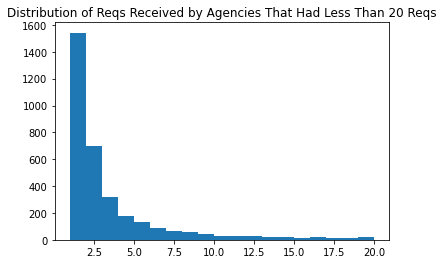

In [48]:
less_than20 = by_agency[by_agency['Requests Received'] <= 20]
plt.title('Distribution of Reqs Received by Agencies That Had Less Than 20 Reqs')
plt.hist(less_than20['Requests Received'], bins = 19);

## How many requests were received by law enforcement agencies in each jurisdiction level? ##

In [7]:
by_jurlevel = police_reqs["Jurisdiction Level"].value_counts().to_frame().reset_index().rename(columns = {'index': 'Jurisdiction Level', 'Jurisdiction Level': 'Requests Received'})
by_jurlevel

#by_jurlevel.to_csv('numRequests_byJurisdiction.csv', index = False)

,Jurisdiction Level,Requests Received
0,Local,19063
1,State,2279
2,Federal,43


## How quickly on average do law enforcement agencies respond to requests versus non-law enforcement agencies?

The issue with the dataset is that there are some entries that never had the "Date Done" column filled out or there were errors with the entry where the date was entered incorrectly. Errors include:
- Completing the entry on the same day but instead of entering the "Date Done" to be the next day, the same date was entered leading to a negtive time difference. 
- Date is just entered incorrectly. 

For a simple fix, the ```replaceNegatives``` function is used to change the "Days Till Completion" value to be positive. 
Next, for calculating the mean, entries without a Date Done entry are excluded as well as entries where the dates were entered incorrectly.

In [8]:
def replaceNegatives(x):
    """
        x: input, a timedelta object
        output: the same timedelta object or the adjusted timedelta object
        
        The completion date for some entries were inputted to be the same date instead of the next date which resulted in a negative
        difference between the Date Done and the Date Submitted. Adding 1 to the time changes the time difference from being 
        "-1 days and XX hours" to be "0 days and XX hours".
    """

    if x.days == -1:
        x += timedelta(days = 1)
        return x
    return x

In [9]:
#convert dates to a datetime object for easy manipulation
police_reqs['Date Submitted'] = pd.to_datetime(police_reqs['Date Submitted'])
police_reqs['Date Due'] = pd.to_datetime(police_reqs['Date Due'])
police_reqs['Date Done'] = pd.to_datetime(police_reqs['Date Done'])

non_police_reqs['Date Submitted'] = pd.to_datetime(non_police_reqs['Date Submitted'])
non_police_reqs['Date Due'] = pd.to_datetime(non_police_reqs['Date Due'])
non_police_reqs['Date Done'] = pd.to_datetime(non_police_reqs['Date Done'])

In [10]:
#find time it took for agency to complete request
police_reqs['Days Till Completion'] = police_reqs['Date Done'] - police_reqs['Date Submitted']
non_police_reqs['Days Till Completion'] = non_police_reqs['Date Done'] - non_police_reqs['Date Submitted']

In [11]:
# remove null values: entries where "Date Done" was never entered
police_completed = police_reqs[~pd.isnull(police_reqs['Days Till Completion'])]
non_police_completed = non_police_reqs[~pd.isnull(non_police_reqs['Days Till Completion'])]

# exclude entries where the difference in time was less than -1
police_completed = police_completed[police_completed['Days Till Completion'] >= timedelta(days = -1)]
non_police_completed = non_police_completed[non_police_completed['Days Till Completion'] >= timedelta(days = -1)]

#apply function to adjust for -1 day differences
police_completed['Days Till Completion'] = police_completed['Days Till Completion'].apply(replaceNegatives)
non_police_completed['Days Till Completion'] = non_police_completed['Days Till Completion'].apply(replaceNegatives)

In [12]:
#calculate mean
non_police_time = np.mean(non_police_completed['Days Till Completion'])
police_time = np.mean(police_completed['Days Till Completion'])

#calculate proportion of removed entries
prop_nonresponse_police = 1 - len(police_completed)/len(police_reqs)
prop_nonresponse_nonpolice = 1 - len(non_police_completed)/len(non_police_reqs)

In [13]:
print("Law enforcement response time to requests: ", police_time.round('1min') ,"\nNon-Law Enforcement response time: ", 
      non_police_time.round('1min'))
print("\nMeans calculated with nonresponse and incorrect entries omitted. \nProportion of omitted entries for police records: ", 
      round(prop_nonresponse_police, 4), "\nProportion of omitted non-police records: ", round(prop_nonresponse_nonpolice, 4))

Law enforcement response time to requests:  96 days 15:02:00 
Non-Law Enforcement response time:  151 days 16:29:00

Means calculated with nonresponse and incorrect entries omitted. 
Proportion of omitted entries for police records:  0.3301 
Proportion of omitted non-police records:  0.3326


## How quickly on average does each individual law enforcement agency respond to requests? 

In [14]:
avg_time = police_completed.groupby('Agency').agg({'Days Till Completion': pd.Series.mean}).reset_index().rename(
    columns = {'Days Till Completion': 'Avg Days Till Completion'})
#avg_time.to_csv('Avg Time of Response by Agency.csv', index = False)

#first 5 records, check csv for full list
avg_time.head()

,Agency,Avg Days Till Completion
0,Abbevile Police Department,31 days 20:00:00
1,Abbeville Police Department,97 days 20:37:43.811949
2,Aberdeen Police Department,30 days 19:03:00.422427250
3,Abilene Texas Police Department,252 days 20:49:24.204696500
4,Abington Police Department,19 days 07:08:21.447689111


## Percentage of Requests under Each Status ##

A column for the total number of requests has been added. The rest of the values show the proportion of requests that are under each status rounded to 4 decimal places if necessary. The table has been sorted alphabetically.

There are some agencies that don't have many requests so the rates can be quite misleading if only sorted by any of the statuses. Something we can do is to only include agencies that have more than a certain number of requests to get a better idea of which agencies are able to complete a large proportion of their requests, but choosing the cutoff number would be arbritrary and needs more discussion.

### For Law Enforcement ###

In [15]:
police_status = police_reqs.pivot_table(columns = 'Status', index = 'Agency', aggfunc = 'size', fill_value = 0)
police_status['Total Number of Requests'] = police_status.sum(axis=1)
for col in police_status.columns:
    if col != "Total Number of Requests":
        police_status[col] = police_status[col]/police_status['Total Number of Requests']*100
police_status = police_status.round(4)
#police_status.to_csv('Law Enforcement - Proportion of Requests under Each Status.csv', index = False)

police_status.head()

Status,Awaiting Acknowledgement,Awaiting Appeal,Awaiting Response,Completed,Fix Required,In Litigation,No Responsive Documents,Partially Completed,Payment Required,Processing,Rejected,Withdrawn,Total Number of Requests
Agency,,,,,,,,,,,,,
Abbevile Police Department,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1
Abbeville Police Department,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1
Aberdeen Police Department,20.0,0.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,5
Abilene Texas Police Department,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
Abington Police Department,0.0,0.0,0.0,20.0,0.0,0.0,60.0,0.0,10.0,0.0,10.0,0.0,10


### For Non-Law Enforcement ###

In [16]:
non_police_status = non_police_reqs.pivot_table(columns = 'Status', index = 'Agency', aggfunc = 'size', fill_value = 0)
non_police_status['Total Number of Requests'] = non_police_status.sum(axis=1)

for col in non_police_status.columns:
    if col != "Total Number of Requests":
        non_police_status[col] = non_police_status[col]/non_police_status['Total Number of Requests']*100
non_police_status = non_police_status.round(4)

#non_police_status.to_csv('Non-Law Enforcement- Proportion of Requests under Each Status.csv', index = False)

non_police_status.head()

Status,Awaiting Acknowledgement,Awaiting Appeal,Awaiting Response,Completed,Fix Required,In Litigation,No Responsive Documents,Partially Completed,Payment Required,Processing,Rejected,Withdrawn,Total Number of Requests
Agency,,,,,,,,,,,,,
"101st Airborne Division, U.S. Army",0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,3
10th Judicial District Drug and Violent Crime Task Force,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,2
"162nd Wing, Arizona Air National Guard",0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
193d Special Operations Wing,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,50.0,2
1st Marine Division,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## State Level Differences ##
### Status Distribution by State for Police/LawEnf ###

In [17]:
police_state_data = pd.DataFrame()

for state in police_reqs["Jurisdiction State"].unique():
    state_only = police_reqs.loc[police_reqs["Jurisdiction State"].str.contains(state, case=False)]
    state_array = state_only["Status"].value_counts()
    police_state_data [state] = round(state_array*100/sum(state_array),2)
    
police_state_data ["Variation between Max and Min"] = police_state_data .max(axis=1) - police_state_data .min(axis=1)
police_state_data = police_state_data.transpose()
police_state_data.index.names = ["State"]
police_state_data = police_state_data.fillna(0)
police_state_data.head()

,Completed,No Responsive Documents,Awaiting Response,Payment Required,Fix Required,Rejected,Withdrawn,Partially Completed,Awaiting Acknowledgement,Awaiting Appeal,In Litigation
State,,,,,,,,,,,
Washington,37.38,19.47,10.70,8.41,7.81,6.61,4.93,3.37,0.84,0.36,0.12
Utah,27.34,35.94,3.91,3.12,10.16,6.25,8.59,0.78,3.91,0.00,0.00
Oklahoma,44.12,31.18,2.94,2.35,7.06,5.88,1.18,1.76,1.76,1.18,0.00
Massachusetts,32.69,29.53,3.79,3.40,4.03,9.73,9.78,1.87,4.31,0.62,0.14
Illinois,54.07,20.53,4.78,0.09,6.64,6.46,3.10,1.24,1.86,0.80,0.44


### Status Distribution by State for non_police ###

In [18]:
non_police_state_data = pd.DataFrame()

for state in non_police_reqs["Jurisdiction State"].unique():
    state_only = non_police_reqs.loc[non_police_reqs["Jurisdiction State"].str.contains(state, case=False)]
    
    state_array = state_only["Status"].value_counts()
    non_police_state_data[state] = round(state_array*100/sum(state_array),2)
    
non_police_state_data["Variation between Max and Min"] = non_police_state_data.max(axis=1) - non_police_state_data.min(axis=1)
non_police_state_data = non_police_state_data.transpose()
non_police_state_data.index.names = ["State"]
non_police_state_data.sort_values(by="Completed").head()
non_police_state_data = non_police_state_data.fillna(0)
non_police_state_data.head()

,Completed,Rejected,Withdrawn,No Responsive Documents,Fix Required,Awaiting Acknowledgement,Awaiting Response,Payment Required,Partially Completed
State,,,,,,,,,
Tennessee,30.72,23.79,13.39,12.93,10.62,4.85,2.31,1.15,0.23
United States of America,30.28,12.61,6.90,22.71,7.24,2.85,13.97,0.54,1.02
New York,44.69,13.01,4.87,21.15,4.41,2.33,7.15,0.62,0.93
Illinois,47.97,6.92,7.03,20.75,8.89,3.62,2.52,0.11,0.55
Alabama,29.75,12.56,32.07,9.75,4.46,5.29,0.99,1.65,3.31


## Difference in Status Distribution between police and non police
***Important*** 
Differences calculated as police - non_police <br>
***Positive***: Police have higher rate of completion/rejection than non-police
***Negative***: Police have lower rate of completion/rejection


So negative completion and positive rejection would be in line with the "transparency exception" hypothesis

In [19]:
combined_state = police_state_data.merge(non_police_state_data, on="State", suffixes=('_Police', '_nonLE'))[["Completed_Police","Completed_nonLE",
                                                                                      "Rejected_Police","Rejected_nonLE"]]
                                                                                                                                                                    
                                                                                     
combined_state["Completed Diff"]= combined_state["Completed_Police"] - combined_state["Completed_nonLE"]


combined_state["Rejected Diff"]= combined_state["Rejected_Police"] - combined_state["Rejected_nonLE"]

combined_state.iloc[:,[0,1,4,2,3,5]]


combined_state.loc[:,["Completed Diff", "Rejected Diff"]].head()

,Completed Diff,Rejected Diff
State,,
Washington,-20.41,2.84
Utah,-9.34,-4.30
Oklahoma,6.85,-3.67
Massachusetts,-0.18,7.38
Illinois,6.10,-0.46


## Requests Received by Each State ##

In [20]:
police_req_count_state = police_reqs.groupby("Jurisdiction State")[["URL"]].count()
police_req_count_state.index.names = ["State"]

non_police_req_count_state =non_police_reqs.groupby("Jurisdiction State")[["URL"]].count()
non_police_req_count_state.index.names = ["State"]

combined_count_by_state = police_req_count_state.merge(non_police_req_count_state, on="State", suffixes=('_Police', '_NonPolice')).rename(
columns={"URL_Police": "Num Police Reqs", "URL_NonPolice": "Num Non-Police Reqs"})

combined_count_by_state["Proportion Police Requests"] = combined_count_by_state["Num Police Reqs"] /sum(
    combined_count_by_state["Num Police Reqs"],combined_count_by_state["Num Non-Police Reqs"])


combined_count_by_state.sort_values(by="Proportion Police Requests", ascending=False).head()

,Num Police Reqs,Num Non-Police Reqs,Proportion Police Requests
State,,,
California,3167,2935,0.130222
Massachusetts,2086,4347,0.081066
New York,1657,1929,0.071073
Texas,1266,903,0.056802
Illinois,1130,911,0.050682


<h1> <font: red>Difference in Response (Completion) Times Between States

### Average completion time per state—police requests

In [21]:
police_state_time_data = pd.DataFrame()

for state in police_reqs["Jurisdiction State"].unique():
    mean_response = police_reqs.loc[police_reqs["Jurisdiction State"]==state][["Days Till Completion"]].mean()
    police_state_time_data[state] = mean_response
police_state_time_data =police_state_time_data.transpose()
police_state_time_data.rename(columns={"Days Till Completion":"Mean Time to Complete: Police"},inplace=True)
police_state_time_data.sort_values(by="Mean Time to Complete: Police").head()
police_state_time_data.index.names = ["State"]

police_state_time_data.sort_values(by="Mean Time to Complete: Police").head()

,Mean Time to Complete: Police
State,
Rhode Island,21 days 18:08:24.776280898
Maine,32 days 00:50:06.525581246
Vermont,35 days 11:43:49.224016549
Idaho,39 days 01:56:27.168339400
Kentucky,44 days 09:22:33.108131857


### Average completion time per state—nonpolice requests


In [22]:
non_police_state_time_data = pd.DataFrame()

for state in non_police_reqs["Jurisdiction State"].unique():
    mean_response = non_police_reqs.loc[non_police_reqs["Jurisdiction State"]==state][["Days Till Completion"]].mean()
    non_police_state_time_data[state] = mean_response

    
non_police_state_time_data=non_police_state_time_data.transpose()
non_police_state_time_data.rename(columns={"Days Till Completion":"Mean Time to Complete: Non Police"},inplace=True)
non_police_state_time_data.index.names = ["State"]
non_police_state_time_data.sort_values(by="Mean Time to Complete: Non Police").head()


,Mean Time to Complete: Non Police
State,
Rhode Island,19 days 04:17:56.258007758
North Dakota,28 days 05:51:31.396273591
West Virginia,30 days 07:53:52.901694186
Iowa,41 days 10:47:39.644742544
Guam,42 days 05:50:45.400697333


### Now add to our existing combined dataset (which compares completion rates)  to assess difference in mean times across states
Positive indicates police take longer. Negative indicates police take shorter. 

In [23]:
combined_state= combined_state.merge(non_police_state_time_data, on="State").merge(police_state_time_data, on="State")

#find difference in mean times, rounded to 1 day
combined_state["Mean Time Diff"] = (combined_state["Mean Time to Complete: Police"] - combined_state["Mean Time to Complete: Non Police"]).round("1d")

diff_in_compl_rej_mean_time = combined_state[["Completed Diff", "Rejected Diff", "Mean Time Diff"]]

diff_in_compl_rej_mean_time


,Completed Diff,Rejected Diff,Mean Time Diff
State,,,
Washington,-20.41,2.84,-4 days
Utah,-9.34,-4.30,-19 days
Oklahoma,6.85,-3.67,7 days
Massachusetts,-0.18,7.38,78 days
Illinois,6.10,-0.46,-2 days
California,5.60,1.20,22 days
Arizona,-5.66,1.38,52 days
Georgia,10.40,-2.11,-36 days
Idaho,-3.96,-3.45,-5 days


<h1> Some visualizations to illustrate differences in rejection/completion/response time BY STATE

### Positive indicates police take longer in that state or have a higher rate ###

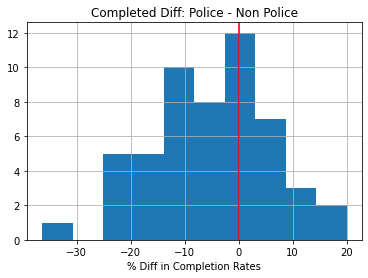

In [24]:
combined_state.hist("Completed Diff")
plt.title("Completed Diff: Police - Non Police")
plt.xlabel("% Diff in Completion Rates")
plt.axvline(0, color="red");

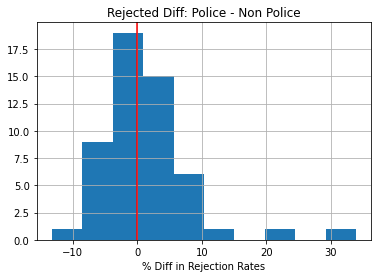

In [25]:
combined_state.hist("Rejected Diff")
plt.title("Rejected Diff: Police - Non Police")
plt.xlabel("% Diff in Rejection Rates")
plt.axvline(0, color="red");

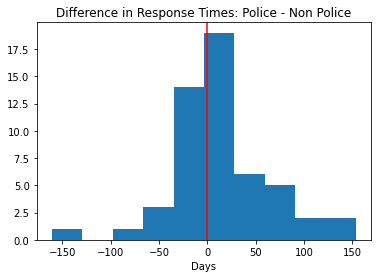

In [26]:
#time delta is hard to plot
days = []
for i in np.arange(len(combined_state["Mean Time Diff"])):
    days.append(combined_state["Mean Time Diff"][i].days)

plt.hist(days)
plt.axvline(0, color="red")
plt.xlabel("Days")
plt.title("Difference in Response Times: Police - Non Police");